In [1]:
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision as torchvision
import torch.optim as optim
from tqdm.notebook import tqdm
import time
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import requests

In [2]:
proxies = {'http': 'llfs.ops.yahoo.com:4080', 'https': 'llfs.ops.yahoo.com:4080'}
headers = {'Accept-Encoding': 'identity', 'user-agent': 'yahoo Slurp'}
r = requests.get('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', headers=headers,proxies=proxies, verify=False, timeout=5)
with open('cifar-10-python.tar.gz', 'wb+') as f:
        f.write(r.content)

/usr/local/lib/python3.6/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'llfs.ops.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [13]:
class AverageMeter(object):
    def __init__(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
# from fastai code
def top_k_accuracy(inp, targ, k=1, axis=-1):
    "Computes the Top-k accuracy (`targ` is in the top `k` predictions of `inp`)"
    inp = inp.topk(k=k, dim=axis)[1]
    targ = targ.unsqueeze(dim=axis).expand_as(inp)
    return (inp == targ).sum(dim=-1).float().mean()

In [195]:
std,mean = [0.229, 0.224, 0.225],[0.485, 0.456, 0.406] # pretrained models used these values

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

 
train_ds = torchvision.datasets.CIFAR10('data/', download=False, train=True, transform=train_transform,)
test_ds = torchvision.datasets.CIFAR10('data/', download=False, train=False, transform=eval_transform,)

In [196]:
train_ds[0][0].shape

torch.Size([3, 32, 32])

In [197]:
bs = 128
train_dl = DataLoader(train_ds, batch_size=bs,shuffle=True)
test_dl = DataLoader(test_ds, batch_size=bs)

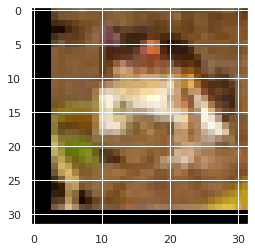

In [198]:
def my_imshow(img, title='', std=std, mean=mean):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.figure (figsize = (4, 4))
    plt.imshow(img)
    plt.title(title)

my_imshow(train_ds[0][0])

In [220]:
# fit/test function
def single_epoch(dataloader, model, loss_function, optimizer=None, callback=None, scheduler=None):

    if optimizer != None:
        model.train()
    else:
        model.eval()

    losses = AverageMeter()
    accuracy = AverageMeter()
    for xb, yb in tqdm(dataloader,leave=False):

        y_hat = model(xb.to(device))
        y = yb.to(device)
        loss = loss_function(y_hat, y)

        if optimizer != None:
            loss.backward()
            optimizer.step()
            if callback != None: callback.on_backward_end(model)
            optimizer.zero_grad()
            if scheduler != None: scheduler.step()

        batch_size = len(yb)
        losses.update(loss.item(), batch_size)
        accuracy.update(top_k_accuracy(y_hat,y,1).item(), batch_size)

    return losses.avg ,accuracy.avg


def fit(epochs, model, train_dl, valid_dl, loss_func, optimizer, scheduler=None, callback=None):
    for epoch in range(epochs):
        lr = scheduler.get_last_lr()[0]
        start_time = time.time()
        train_loss,train_acc = single_epoch(train_dl, model, loss_func, optimizer, callback, scheduler)
        with torch.no_grad():
            valid_loss,valid_acc = single_epoch(valid_dl, model, loss_func, callback=callback)
        secs = int(time.time() - start_time)
        print(f'Epoch {epoch} {secs}[sec] lr={lr:.5f}',end=' ')
        print(f'Train: loss {train_loss:.4f} accuracy {train_acc:.4f}',end='\t')
        print(f'Validation: loss {valid_loss:.4f} accuracy {valid_acc:.4f}')

In [200]:
class GradAveregeCallBack():
    def __init__(self):
        self.grads = []

    def on_backward_end(self, model):
        average_grads = []
        for n, p in model.named_parameters():
            if(p.requires_grad) and ("bias" not in n) and len(p.shape) != 1: # not batch_norm
                average_grads.append(p.grad.abs().mean().item())        
        self.grads.append(average_grads)

In [201]:
def plot_grads(grads, iterations=10):
    f, axes = plt.subplots(1, 1,figsize = (10, 10))
    lines = iterations
    pallet = sns.color_palette("Blues_d",lines)
    for i in range(0,lines):
        sns.lineplot(x=range(1,12), y=grads[i], color=pallet[i], ax=axes)

In [202]:
loss_function = nn.CrossEntropyLoss().to(device)

In [203]:
def get_model(bn=False, activation=None):
    if bn:
        model = models.vgg11_bn(pretrained=False)
    else:
        model = models.vgg11(pretrained=False)

    # update number of output
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)

    # replace relu with activation
    if activation != None:
        for i,l in enumerate(model.features):
            if type(l) == nn.ReLU:
                model.features[i] = activation

        for i,l in enumerate(model.classifier):
            if type(l) == nn.ReLU:
                model.classifier[i] = activation

    model = model.to(device)
    opt = optim.SGD(params=model.parameters(), lr=0.05, weight_decay=1e-3,momentum=0.9)
    return model, opt

In [219]:
epochs = 50
model, opt = get_model()
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, 0.05, epochs=epochs, steps_per_epoch=len(train_dl))

grads_cb = GradAveregeCallBack()
fit(epochs, model, train_dl, test_dl, loss_function, opt, scheduler=scheduler, callback=grads_cb)

[0.0020000000000000018]

In [216]:
def plot_grads(grads, iterations=10):
    f, axes = plt.subplots(1, 1,figsize = (10, 10))
    lines = iterations
    pallet = sns.color_palette("Blues_d",lines)
    for i in range(0,lines):
        sns.lineplot(x=range(1,12), y=grads[i],color=pallet[i],ax=axes)

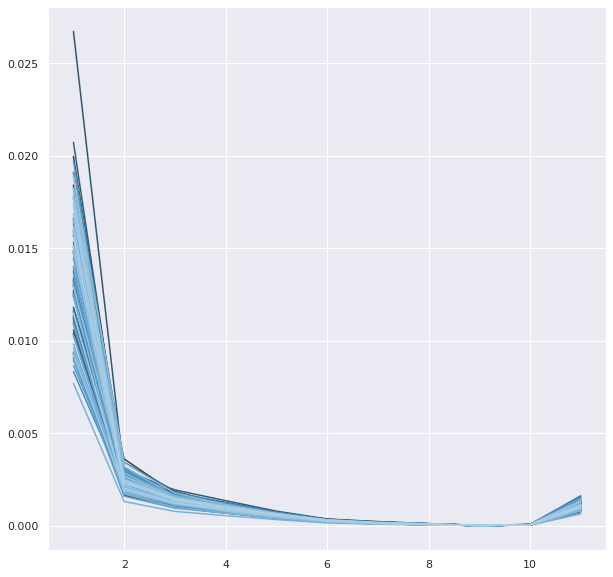

In [221]:
plot_grads(grads_cb.grads[10000:],100)